In [1]:
#here we rerun the genotype calling including a) the depth channels which required a more supervised approach b) the ATACseq channels.
setwd("~/ben_lustre/current_projects/kidney_glomTI_response")
suppressPackageStartupMessages(source("https://raw.githubusercontent.com/bjstewart1/helpful_singlecell/main/functions.R"))
ad <- import("anndata")
sc <- import("scanpy")
library(GenotypeMixtures)

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [4]:
#get the sequencing inventory and make a multiplexing matrix  - write out the relevant files ####
tenx_dir <- "/lustre/scratch117/cellgen/team297/bs16/10X_data/kidney_perfusion"
sequencing_inventory <- read.csv("~/ben_nfs/sample_donor_data/sequencing_inventory.csv", check.names = FALSE)
sequencing_inventory$irods_ID <- gsub(" ", "", sequencing_inventory$irods_ID)
#take just cells which are 10X_3'V3
multiplex_design <- sequencing_inventory[sequencing_inventory$experiment %in% c("10X_3'_V3") & 
                                           sequencing_inventory$cellranger_SOC %in% 'TRUE' & sequencing_inventory$poor_QC %in% "FALSE",]
#exclude fetal - these are one per channel and we will analyse these elsewhere
multiplex_design <- multiplex_design[!multiplex_design$tissue %in% grep("fetal", multiplex_design$tissue, value = TRUE), ]

In [8]:
perfusion_kidneys = c("K288", "K287", "K281", "K290", "K289", "K282", "K283")
multiplex_design = multiplex_design[grep(paste(perfusion_kidneys, collapse = "|"), multiplex_design$donor), ]

Using channel as id variables



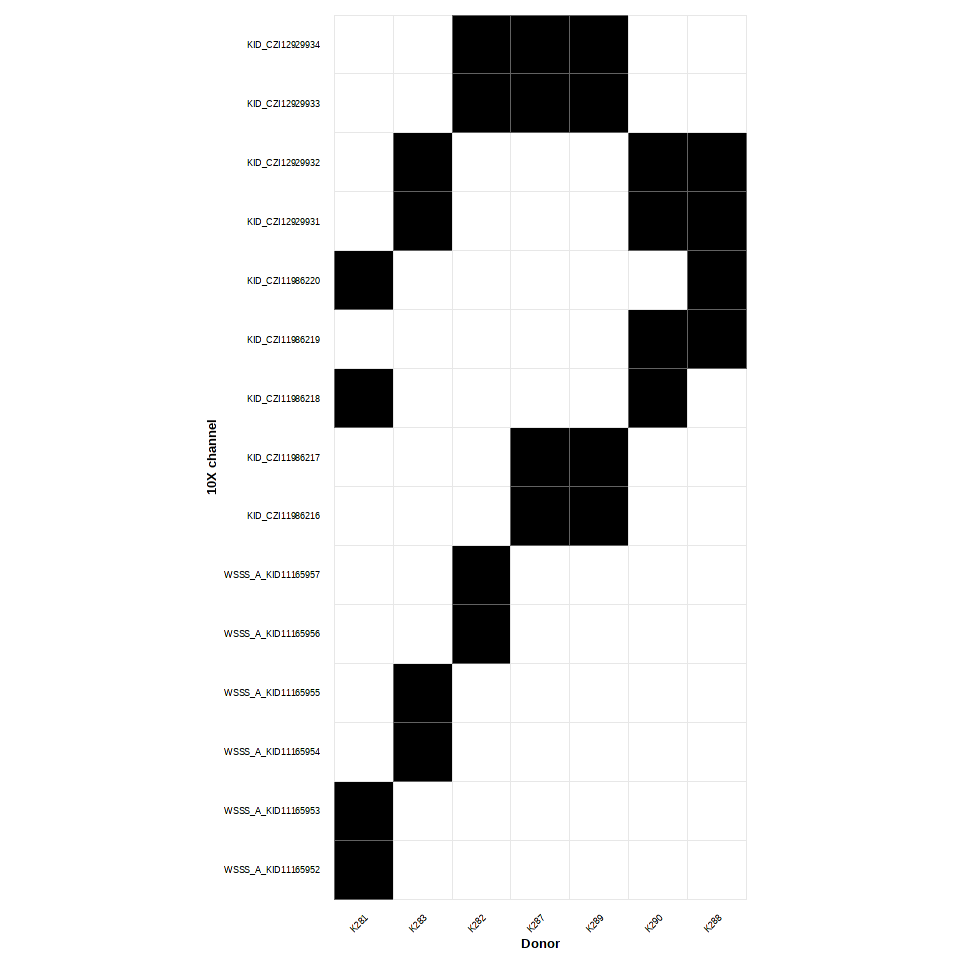

In [25]:
options(repr.plot.width = 8, repr.plot.height = 8)
plot_experimental_design(multiplexing_mat)

In [27]:
#get the locations of the files ####
dirs <- multiplex_design[match(multiplex_design$sanger_ID, rownames(multiplexing_mat)), "10xDIR"]
locations <- data.frame("channel" = rownames(multiplexing_mat), 
                        "SOC_location" = file.path("/lustre/scratch117/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/seq_data", '10X_3p', multiplex_design$irods_ID, "SOC_common_variants"))

In [29]:
#make multiplexing mat into a donor mat
multiplexing_mat = data.frame(multiplexing_mat)
multiplexing_mat$donor1 = multiplexing_mat[, 'K281']
multiplexing_mat$donor2 = rowSums(multiplexing_mat[, c('K282', 'K283')])
multiplexing_mat$donor3 = rowSums(multiplexing_mat[, c('K287', 'K288')])
multiplexing_mat$donor4 = rowSums(multiplexing_mat[, c('K289', 'K290')])
multiplexing_mat = multiplexing_mat[, -c(1:7)]

In [30]:
multiplexing_mat

,donor1,donor2,donor3,donor4
,<dbl>,<dbl>,<dbl>,<dbl>
WSSS_A_KID11165952,1,0,0,0
WSSS_A_KID11165953,1,0,0,0
WSSS_A_KID11165954,0,1,0,0
WSSS_A_KID11165955,0,1,0,0
WSSS_A_KID11165956,0,1,0,0
WSSS_A_KID11165957,0,1,0,0
KID_CZI11986216,0,0,1,1
KID_CZI11986217,0,0,1,1
KID_CZI11986218,1,0,0,1


Using channel as id variables



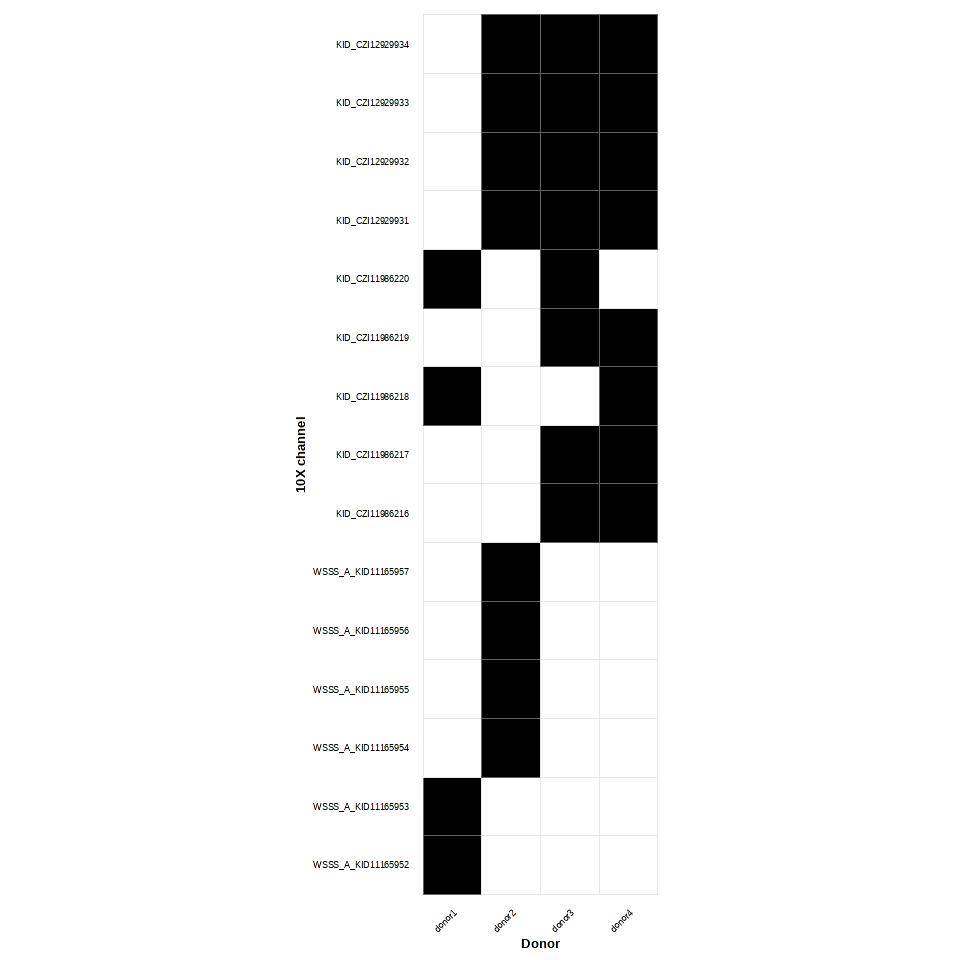

In [31]:
options(repr.plot.width = 8, repr.plot.height = 8)
plot_experimental_design(multiplexing_mat)

In [32]:
genotype_clustering_output <- construct_genotype_cluster_graph(experimental_design = multiplexing_mat, 
                                                               file_locations = locations, ncounts  = 10)

checking files



  |                                                                      |   0%

reading in VCF files


   *****       ***   vcfR   ***       *****
   This is vcfR 1.13.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****




  |======================================================================| 100%


the membership graph is a collection of complete subgraphs as expected



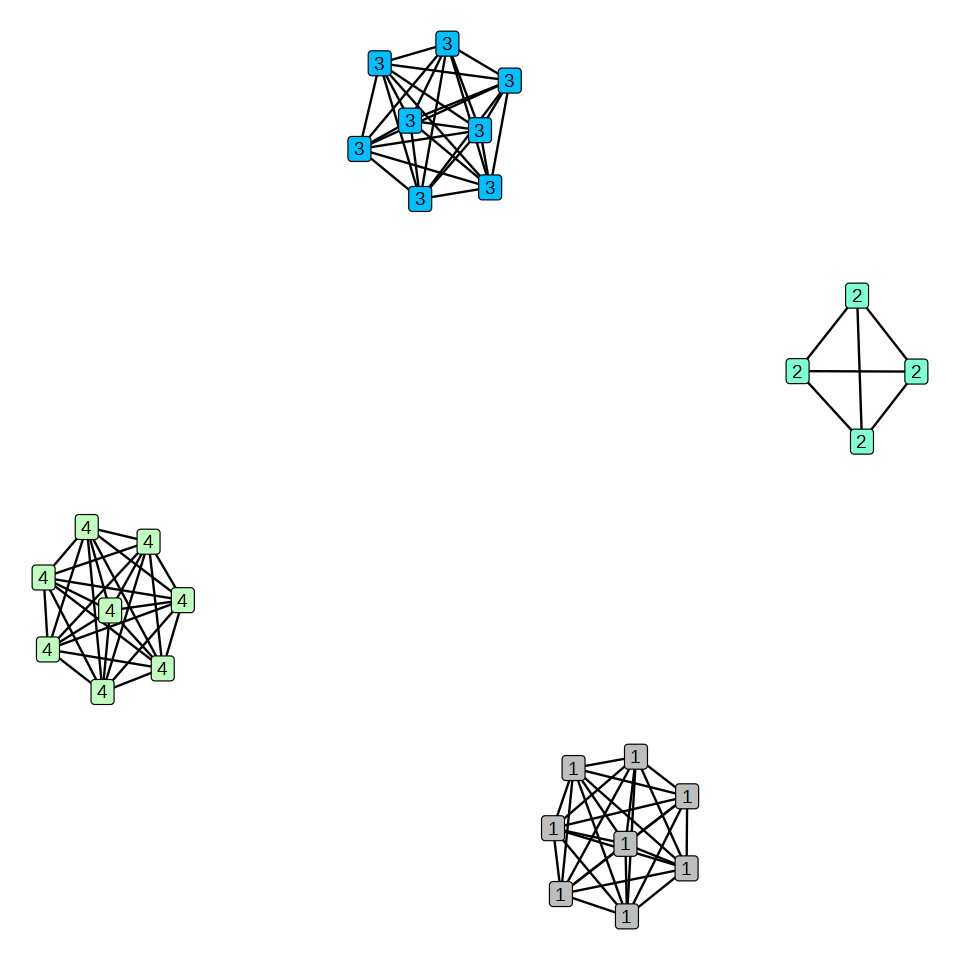

In [33]:
genotype_clustering_output$graph_plot

In [34]:
cluster_mapping <- membership_map(experimental_design = multiplexing_mat,
                                  graph_output =  genotype_clustering_output)

In [35]:
cell_assignments <- cells_to_genotypes(SOC_locations = locations, 
                                       membership_mat =cluster_mapping)

In [36]:
head(cell_assignments)

,barcode,status,assignment,channel,genotype,SOC_cluster
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,AAACCCAAGCTCGTGC-1,singlet,0,WSSS_A_KID11165952,donor1,WSSS_A_KID11165952_0
2,AAACCCAAGGCAGGGA-1,singlet,0,WSSS_A_KID11165952,donor1,WSSS_A_KID11165952_0
3,AAACCCACACGGGTAA-1,singlet,0,WSSS_A_KID11165952,donor1,WSSS_A_KID11165952_0
4,AAACCCACACTAGGCC-1,singlet,0,WSSS_A_KID11165952,donor1,WSSS_A_KID11165952_0
5,AAACCCACAGAACTAA-1,singlet,0,WSSS_A_KID11165952,donor1,WSSS_A_KID11165952_0
6,AAACCCACAGCCCACA-1,singlet,0,WSSS_A_KID11165952,donor1,WSSS_A_KID11165952_0


In [37]:
table(cell_assignments$genotype, cell_assignments$channel)

               
                KID_CZI11986216 KID_CZI11986217 KID_CZI11986218 KID_CZI11986219
  donor1                      0               0            1777               0
  donor1/donor3               0               0               0               0
  donor1/donor4               0               0              30               0
  donor2                      0               0               0               0
  donor2/donor3               0               0               0               0
  donor2/donor4               0               0               0               0
  donor3                   5432            4438               0             534
  donor3/donor1               0               0               0               0
  donor3/donor2               0               0               0               0
  donor3/donor4            1543              97               0              18
  donor4                   8981            2684            1192            2889
  donor4/donor1         

In [38]:
#then make a dataframe of stimulation kidney anatomy and channel
table(cell_assignments$channel)


   KID_CZI11986216    KID_CZI11986217    KID_CZI11986218    KID_CZI11986219 
             18083               7331               3019               3486 
   KID_CZI11986220    KID_CZI12929931    KID_CZI12929932    KID_CZI12929933 
              2048               2050               5592               6274 
   KID_CZI12929934 WSSS_A_KID11165952 WSSS_A_KID11165953 WSSS_A_KID11165954 
              7881               4750               4101               3345 
WSSS_A_KID11165955 WSSS_A_KID11165956 WSSS_A_KID11165957 
              2139               1184               2565 

In [39]:
#now we read these back to the tissue
idx_df =  data.frame(do.call(rbind, list(
c("WSSS_A_KID11165952", "K281", "GLOM", "donor1"),
c("WSSS_A_KID11165953", "K281", "TI", "donor1"),
c("WSSS_A_KID11165954", "K283", "GLOM", "donor2"),
c("WSSS_A_KID11165955", "K283", "TI", "donor2"),
c("WSSS_A_KID11165956", "K282", "GLOM", "donor2"),
c("WSSS_A_KID11165957", "K282", "TI", "donor2"),
c("KID_CZI11986216", "K287", "GLOM", "donor3"),
c("KID_CZI11986216", "K289", "GLOM", "donor4"),
c("KID_CZI11986217", "K287", "TI", "donor3"),
c("KID_CZI11986217", "K289", "TI", "donor4"),
c("KID_CZI11986218", "K281", "TI", "donor1"),
c("KID_CZI11986218", "K290", "GLOM", "donor4"),
c("KID_CZI11986219", "K288", "TI", "donor3"),
c("KID_CZI11986219", "K290", "TI", "donor4"),
c("KID_CZI11986220", "K281", "GLOM", "donor1"),
c("KID_CZI11986220", "K288", "GLOM", "donor3"),
    
c("KID_CZI12929931", "K283", "GLOM", "donor2"),
c("KID_CZI12929931", "K288", "GLOM", "donor3"),
c("KID_CZI12929931", "K290", "GLOM", "donor4"),

c("KID_CZI12929932", "K283", "TI", "donor2"),
c("KID_CZI12929932", "K288", "TI", "donor3"),
c("KID_CZI12929932", "K290", "TI", "donor4"),

c("KID_CZI12929933", "K282", "GLOM", "donor2"),
c("KID_CZI12929933", "K287", "GLOM", "donor3"),
c("KID_CZI12929933", "K289", "GLOM", "donor4"),

c("KID_CZI12929934", "K282", "TI", "donor2"),
c("KID_CZI12929934", "K287", "TI", "donor3"),
c("KID_CZI12929934", "K289", "TI", "donor4")
)))


In [41]:
cell_assignments$tissue = NA
for(i in rownames(idx_df)){
    ch = idx_df[i, 1]
    don = idx_df[i, 4]
    cell_assignments[cell_assignments$channel %in% ch & cell_assignments$genotype %in% don, "tissue"] = idx_df[i, 3]
    cell_assignments[cell_assignments$channel %in% ch & cell_assignments$genotype %in% don, "kidney"] = idx_df[i, 2]

    }

In [42]:
table(cell_assignments$tissue, cell_assignments$kidney)
table(cell_assignments$tissue, cell_assignments$genotype)
table(cell_assignments$kidney, cell_assignments$genotype)

      
        K281  K282  K283  K287  K288  K289  K290
  GLOM  5137  1835  3913  6729  1797 13041  2457
  TI    5878  4244  3574  7101  1902  5719  5317

      
       donor1 donor1/donor3 donor1/donor4 donor2 donor2/donor3 donor2/donor4
  GLOM   5137             0             0   5748             0             0
  TI     5878             0             0   7818             0             0
      
       donor3 donor3/donor1 donor3/donor2 donor3/donor4 donor4 donor4/donor1
  GLOM   8526             0             0             0  15498             0
  TI     9003             0             0             0  11036             0
      
       donor4/donor2 donor4/donor3
  GLOM             0             0
  TI               0             0

      
       donor1 donor1/donor3 donor1/donor4 donor2 donor2/donor3 donor2/donor4
  K281  11015             0             0      0             0             0
  K282      0             0             0   6079             0             0
  K283      0             0             0   7487             0             0
  K287      0             0             0      0             0             0
  K288      0             0             0      0             0             0
  K289      0             0             0      0             0             0
  K290      0             0             0      0             0             0
      
       donor3 donor3/donor1 donor3/donor2 donor3/donor4 donor4 donor4/donor1
  K281      0             0             0             0      0             0
  K282      0             0             0             0      0             0
  K283      0             0             0             0      0             0
  K287  13830             0             0             0      0

In [44]:
table(cell_assignments$tissue)


 GLOM    TI 
34909 33735 

In [48]:
saveRDS(cluster_mapping, "data/genotypes/perfusion_cluster_mapping.RDS")
saveRDS(cell_assignments, "data/genotypes/perfusion_cell_assignments.RDS")
saveRDS(genotype_clustering_output, "data/genotypes/perfusion_genotype_clustering_output.RDS")

In [49]:
#get ambients
ambient <- unlist(lapply(locations$SOC_location, function(x){
  amb <- read.table(file.path(x, 'ambient_rna.txt'), check.names = FALSE)
  amb <- amb[, 5]
  amb <- as.numeric(gsub("%", "", amb))/100
  return(amb)}))
names(ambient) <- locations$channel
saveRDS(ambient, "data/genotypes/perfusion_ambient_proportions.RDS")

Warning message in read.table(file.path(x, "ambient_rna.txt"), check.names = FALSE):
“incomplete final line found by readTableHeader on '/lustre/scratch117/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/seq_data/10X_3p/cellranger700_count_41742_WSSS_A_KID11165952_GRCh38-2020-A/SOC_common_variants/ambient_rna.txt'”
Warning message in read.table(file.path(x, "ambient_rna.txt"), check.names = FALSE):
“incomplete final line found by readTableHeader on '/lustre/scratch117/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/seq_data/10X_3p/cellranger700_count_41742_WSSS_A_KID11165953_GRCh38-2020-A/SOC_common_variants/ambient_rna.txt'”
Warning message in read.table(file.path(x, "ambient_rna.txt"), check.names = FALSE):
“incomplete final line found by readTableHeader on '/lustre/scratch117/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/seq_data/10X_3p/cellranger700_count_41742_WSSS_A_KID11165954_GRCh38-2020-A/SOC_common_variants/ambient_rna.t

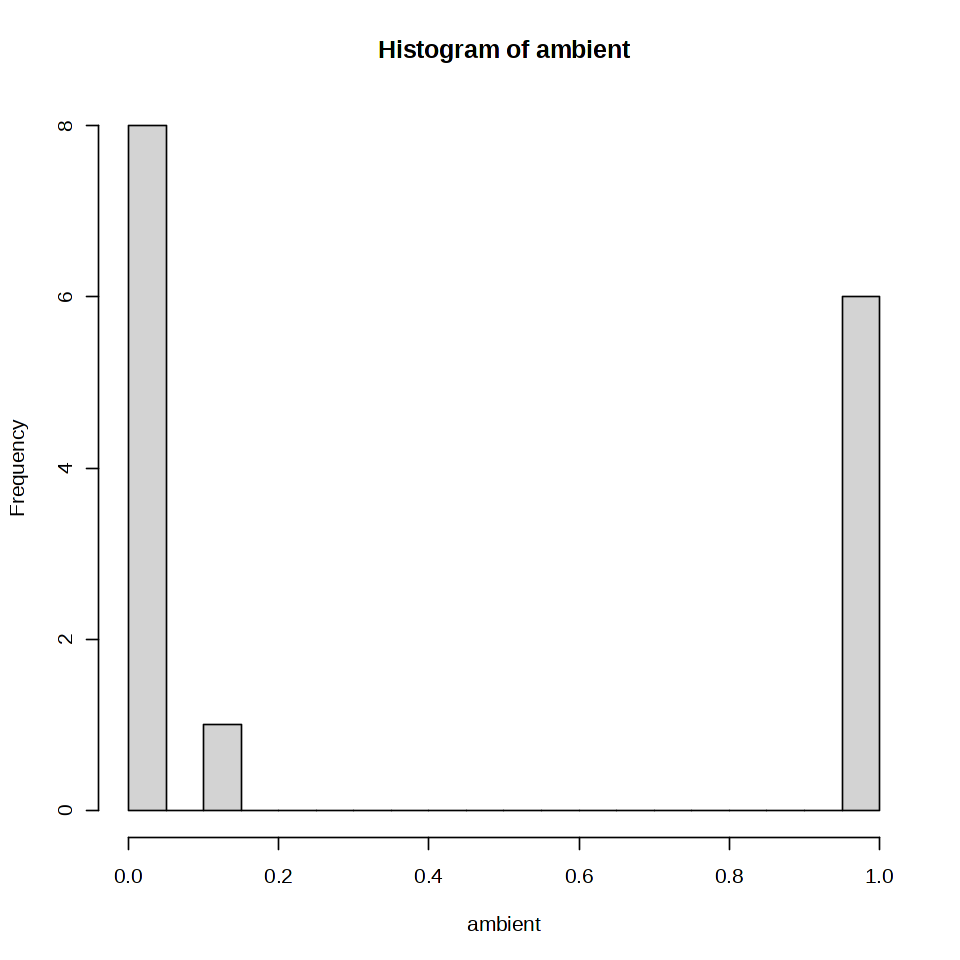

In [50]:
hist(ambient, breaks = 20)